In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest

from joblib import dump
from imblearn.over_sampling import RandomOverSampler
import warnings

warnings.filterwarnings('ignore')
seed = 42

In [2]:
red_wine = pd.read_csv('dataset/winequality-red.csv', sep=';')
white_wine = pd.read_csv('dataset/winequality-white.csv', sep=';')

In [3]:
def features_label_extracting(dataset):
    features = dataset.loc[:, dataset.columns != 'quality']
    labels = dataset.loc[:, 'quality']
    return features, labels

In [4]:
def scaling_splitting_data(x, y, test_size):
    """Data normalization and splitting into training and test samples"""
    x_norm = MinMaxScaler().fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=test_size, random_state=seed)
    return x_train, x_test, y_train, y_test

In [5]:
x_red, y_red = features_label_extracting(red_wine)
x_white, y_white = features_label_extracting(white_wine)

In [6]:
x_train_norm_r, x_test_norm_r, y_train_norm_r, y_test_norm_r = scaling_splitting_data(x_red, y_red, 0.3)
x_train_norm_w, x_test_norm_w, y_train_norm_w, y_test_norm_w = scaling_splitting_data(x_white, y_white, 0.3)

In [7]:
# ML algorithms from sklearn
def creating_models():    
    models = list()
    models.append(('LinearDiscriminant..', LinearDiscriminantAnalysis()))
    models.append(('DecisionTree........', DecisionTreeClassifier(random_state=seed)))
    models.append(('GaussianNB..........', GaussianNB()))
    models.append(('KNeighbors..........', KNeighborsClassifier()))
    models.append(('SupportVector.......', SVC(random_state=seed, gamma='auto')))
    models.append(('Bagging.............', BaggingClassifier(random_state=seed)))
    models.append(('RandomForest........', RandomForestClassifier(random_state=seed)))
    models.append(('ExtraTrees..........', ExtraTreesClassifier(random_state=seed)))
    models.append(('AdaBoost............', AdaBoostClassifier(random_state=seed)))
    models.append(('GradientBoosting....', GradientBoostingClassifier(random_state=seed)))
    return models

In [8]:
def generate_results_of_models(list_of_models, n_folds, score, x, y):
    """Generation of models taking into account cross-validation"""
    for name, model in list_of_models:
        k_fold = KFold(n_splits=n_folds, random_state=seed)
        cv_results = cross_val_score(model, x, y, cv=k_fold, scoring=score)

        print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

In [9]:
num_folds = 3
scoring = 'balanced_accuracy'

The 'balanced_accuracy_score' function computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets. 
If the classifier performs equally well on either class, this term reduces to the conventional accuracy (i.e., the number of correct predictions divided by the total number of predictions).
In contrast, if the conventional accuracy is above chance only because the classifier takes advantage of an imbalanced test set, then the balanced accuracy, as appropriate, will drop to 1/n_classes.

In [10]:
print('Classification results for Red wine labels:\n')
generate_results_of_models(creating_models(), num_folds, scoring, x_train_norm_r, y_train_norm_r)

Classification results for Red wine labels:

LinearDiscriminant..: 0.367172 (0.065620)
DecisionTree........: 0.304873 (0.015611)
GaussianNB..........: 0.356699 (0.057764)
KNeighbors..........: 0.282076 (0.029011)
SupportVector.......: 0.226122 (0.011172)
Bagging.............: 0.287744 (0.009219)
RandomForest........: 0.304191 (0.008730)
ExtraTrees..........: 0.317480 (0.011495)
AdaBoost............: 0.218622 (0.009710)
GradientBoosting....: 0.301712 (0.004627)


In [11]:
print('Classification results for White wine labels:\n')
generate_results_of_models(creating_models(), num_folds, scoring, x_train_norm_w, y_train_norm_w)

Classification results for White wine labels:

LinearDiscriminant..: 0.289591 (0.010989)
DecisionTree........: 0.344674 (0.036263)
GaussianNB..........: 0.326068 (0.032242)
KNeighbors..........: 0.285914 (0.024527)
SupportVector.......: 0.204860 (0.014041)
Bagging.............: 0.360191 (0.026559)
RandomForest........: 0.366860 (0.036792)
ExtraTrees..........: 0.369256 (0.030957)
AdaBoost............: 0.201409 (0.010183)
GradientBoosting....: 0.346325 (0.031986)


## Decrease in the number of classes

Since the classes are not balanced, it is necessary to use undersampling or oversampling methods to correct the distribution of the data set. The undersampling method involves deleting a certain number of samples for classes that are larger than the number of classes. However, due to the size of the sample for red wine, this method is not suitable. There are few lacking class values for using the oversampling method (as can be seen from the notebook 'data_analysis.ipnb').

Therefore, we need to decrease the number of classes. Let's convert the wine quality estimation into three categories and see if it will increase the accuracy of algorithms' work.

* 0 - bad wine from 0 to 4
* 1 - average wine from 4 to 6 
* 2 - good wine from 6 to 10

In [12]:
rating_bins = [0, 4, 6, 10]
rating_labels = [0, 1, 2]

red_wine['quality'] = pd.cut(red_wine['quality'], bins=rating_bins, labels=rating_labels)
white_wine['quality'] = pd.cut(white_wine['quality'], bins=rating_bins, labels=rating_labels)

x_red, y_red = features_label_extracting(red_wine)
x_white, y_white = features_label_extracting(white_wine)

x_train_r, x_test_r, y_train_r, y_test_r = scaling_splitting_data(x_red, y_red, 0.3)
x_train_w, x_test_w, y_train_w, y_test_w = scaling_splitting_data(x_white, y_white, 0.3)

In [13]:
print('Classification results after decreasing the number of classes for Red wine labels:\n')
generate_results_of_models(creating_models(), num_folds, scoring, x_train_r, y_train_r)

Classification results after decreasing the number of classes for Red wine labels:

LinearDiscriminant..: 0.482749 (0.026109)
DecisionTree........: 0.554711 (0.038469)
GaussianNB..........: 0.526587 (0.003533)
KNeighbors..........: 0.433345 (0.003082)
SupportVector.......: 0.333333 (0.000000)
Bagging.............: 0.510329 (0.022451)
RandomForest........: 0.468156 (0.019027)
ExtraTrees..........: 0.466227 (0.008205)
AdaBoost............: 0.512353 (0.023344)
GradientBoosting....: 0.482095 (0.005744)


In [14]:
print('Classification results after decreasing the number of classes for White wine labels:\n')
generate_results_of_models(creating_models(),  num_folds, scoring, x_train_w, y_train_w)

Classification results after decreasing the number of classes for White wine labels:

LinearDiscriminant..: 0.481347 (0.009502)
DecisionTree........: 0.570597 (0.020448)
GaussianNB..........: 0.563105 (0.038627)
KNeighbors..........: 0.474497 (0.007296)
SupportVector.......: 0.333333 (0.000000)
Bagging.............: 0.523327 (0.006172)
RandomForest........: 0.526198 (0.006742)
ExtraTrees..........: 0.537103 (0.001581)
AdaBoost............: 0.538037 (0.031726)
GradientBoosting....: 0.523495 (0.007352)


As can be seen from the estimates of models, balanced accuracy has become much higher after the number of classes has decreased.

## Removal of anomalies from the data

In [15]:
def anomaly_removal(df):
    clf = IsolationForest(max_samples=df.shape[0], max_features=df.shape[1], random_state=seed)
    clf.fit(df)
    predicted_anomaly = clf.predict(df)
    rows_of_anomalies = np.where(predicted_anomaly == -1)
    df_without_anomalies = df.drop(rows_of_anomalies[0])
    df_without_anomalies.reset_index(drop=True, inplace=True)  
    return df_without_anomalies

In [16]:
red_wine_without_anomalies = anomaly_removal(red_wine)
white_wine_without_anomalies = anomaly_removal(white_wine)

x_red_without_anomalies, y_red_without_anomalies = features_label_extracting(red_wine_without_anomalies)
x_white_without_anomalies, y_white_without_anomalies = features_label_extracting(white_wine_without_anomalies)

x_train_r, x_test_r, y_train_r, y_test_r = scaling_splitting_data(x_red_without_anomalies, 
                                                                  y_red_without_anomalies, 0.3)
x_train_w, x_test_w, y_train_w, y_test_w = scaling_splitting_data(x_white_without_anomalies, 
                                                                  y_white_without_anomalies, 0.3)

In [17]:
print('Classification results after removal of anomalies from the Red wine data:\n')
generate_results_of_models(creating_models(), num_folds, scoring, x_train_r, y_train_r)

Classification results after removal of anomalies from the Red wine data:

LinearDiscriminant..: 0.464157 (0.043720)
DecisionTree........: 0.507452 (0.043512)
GaussianNB..........: 0.617934 (0.054045)
KNeighbors..........: 0.445299 (0.025644)
SupportVector.......: 0.333333 (0.000000)
Bagging.............: 0.442930 (0.017215)
RandomForest........: 0.435823 (0.024354)
ExtraTrees..........: 0.444620 (0.011282)
AdaBoost............: 0.546203 (0.067098)
GradientBoosting....: 0.445468 (0.011228)


In [18]:
print('Classification results after removal of anomalies from the White wine data:\n')
generate_results_of_models(creating_models(),  num_folds, scoring, x_train_w, y_train_w)

Classification results after removal of anomalies from the White wine data:

LinearDiscriminant..: 0.451823 (0.010626)
DecisionTree........: 0.551643 (0.014523)
GaussianNB..........: 0.518319 (0.017138)
KNeighbors..........: 0.480536 (0.013834)
SupportVector.......: 0.333333 (0.000000)
Bagging.............: 0.528438 (0.022059)
RandomForest........: 0.509273 (0.010286)
ExtraTrees..........: 0.511201 (0.013837)
AdaBoost............: 0.499185 (0.019673)
GradientBoosting....: 0.482975 (0.019025)


____

In [19]:
def grid_search_for_model(model, n_folds, x, y, parameters):
    """Parameter selection for the model using the GridSearch"""

    k_fold = KFold(n_splits=n_folds, random_state=seed)

    grid = GridSearchCV(estimator=model, param_grid=parameters, scoring=scoring, cv=k_fold)
    grid_result = grid.fit(x, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    for mean, std, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, std, param))

    return grid_result.cv_results_['mean_test_score']

## Adjustment of parameters for the most accurate classifiers

In [20]:
param_grid = dict(n_estimators=np.array([50, 100, 200, 400, 600, 800, 900]), max_depth=[2, 4, 6, 8, 10, 12])
param_grid_estimators = dict(n_estimators=np.array([50, 100, 200, 400, 600, 800, 900]))
param_grid_max_depth = dict(max_depth=[2, 4, 6, 8, 10, 12])

In [21]:
results_red = list()
results_white = list()

#### For red wine

In [22]:
print('Parameters of DecisionTreeClassifier:\n')
results_red.append(grid_search_for_model(DecisionTreeClassifier(random_state=seed), num_folds, 
                                         x_train_r, y_train_r, param_grid_max_depth))
print('\nParameters of BaggingClassifier:\n')
results_red.append(grid_search_for_model(BaggingClassifier(random_state=seed), num_folds,
                                         x_train_r, y_train_r, param_grid_estimators))
print('\nParameters of RandomForestClassifier:\n')
results_red.append(grid_search_for_model(RandomForestClassifier(random_state=seed), num_folds, 
                                         x_train_r, y_train_r, param_grid))
print('\nParameters of ExtraTreesClassifier:\n')
results_red.append(grid_search_for_model(ExtraTreesClassifier(random_state=seed), num_folds,
                                         x_train_r, y_train_r, param_grid))
print('\nParameters of AdaBoostClassifier:\n')
results_red.append(grid_search_for_model(AdaBoostClassifier(random_state=seed), num_folds, 
                                         x_train_r, y_train_r, param_grid_estimators))
print('\nParameters of GradientBoostingClassifier:\n')
results_red.append(grid_search_for_model(GradientBoostingClassifier(random_state=seed), num_folds,
                                         x_train_r, y_train_r, param_grid))

Parameters of DecisionTreeClassifier:

Best: 0.488018 using {'max_depth': 12}
0.428194 (0.015818) with: {'max_depth': 2}
0.426509 (0.015116) with: {'max_depth': 4}
0.429783 (0.007125) with: {'max_depth': 6}
0.449684 (0.006453) with: {'max_depth': 8}
0.456381 (0.025873) with: {'max_depth': 10}
0.488018 (0.035354) with: {'max_depth': 12}

Parameters of BaggingClassifier:

Best: 0.455917 using {'n_estimators': 100}
0.448578 (0.022885) with: {'n_estimators': 50}
0.455917 (0.027970) with: {'n_estimators': 100}
0.452061 (0.017211) with: {'n_estimators': 200}
0.452407 (0.017945) with: {'n_estimators': 400}
0.450014 (0.016941) with: {'n_estimators': 600}
0.452792 (0.017423) with: {'n_estimators': 800}
0.452792 (0.017423) with: {'n_estimators': 900}

Parameters of RandomForestClassifier:

Best: 0.443858 using {'max_depth': 12, 'n_estimators': 50}
0.335979 (0.003741) with: {'max_depth': 2, 'n_estimators': 50}
0.333333 (0.000000) with: {'max_depth': 2, 'n_estimators': 100}
0.333333 (0.000000) wit

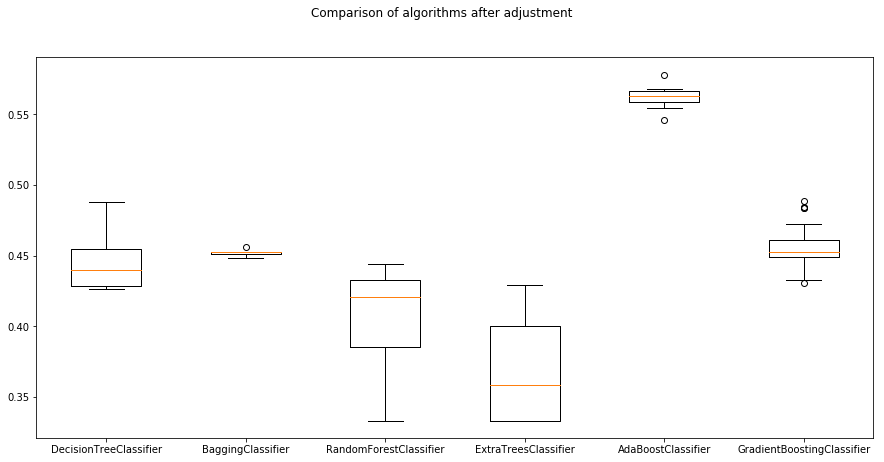

In [23]:
names = ['DecisionTreeClassifier', 'BaggingClassifier', 'RandomForestClassifier', 
         'ExtraTreesClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier']
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Comparison of algorithms after adjustment')
ax = fig.add_subplot(111)
plt.boxplot(results_red)
ax.set_xticklabels(names)
plt.show()

Based on the high median value, minimum asymmetry of whiskers and the minimum value of the interval distribution range (box), we can conclude that the best results of the quality assessment of Red wine in the training sample showed AdaBoostClassifier.

#### For white wine

In [24]:
print('Parameters of DecisionTreeClassifier:\n')
results_white.append(grid_search_for_model(DecisionTreeClassifier(random_state=seed), num_folds, 
                                           x_train_w, y_train_w, param_grid_max_depth))
print('\nParameters of BaggingClassifier:\n')
results_white.append(grid_search_for_model(BaggingClassifier(random_state=seed), num_folds, 
                                           x_train_w, y_train_w, param_grid_estimators))
print('\nParameters of RandomForestClassifier:\n')
results_white.append(grid_search_for_model(RandomForestClassifier(random_state=seed), num_folds,
                                           x_train_w, y_train_w, param_grid))
print('\nParameters of ExtraTreesClassifier:\n')
results_white.append(grid_search_for_model(ExtraTreesClassifier(random_state=seed), num_folds,
                                           x_train_w, y_train_w, param_grid))
print('\nParameters of AdaBoostClassifier:\n')
results_white.append(grid_search_for_model(AdaBoostClassifier(random_state=seed), num_folds, 
                                           x_train_w, y_train_w, param_grid_estimators))
print('\nParameters of GradientBoostingClassifier:\n')
results_white.append(grid_search_for_model(GradientBoostingClassifier(random_state=seed), num_folds,
                                           x_train_w, y_train_w, param_grid))

Parameters of DecisionTreeClassifier:

Best: 0.529192 using {'max_depth': 12}
0.394590 (0.007854) with: {'max_depth': 2}
0.424957 (0.030523) with: {'max_depth': 4}
0.460655 (0.023462) with: {'max_depth': 6}
0.501752 (0.019836) with: {'max_depth': 8}
0.508393 (0.014972) with: {'max_depth': 10}
0.529192 (0.031740) with: {'max_depth': 12}

Parameters of BaggingClassifier:

Best: 0.527278 using {'n_estimators': 800}
0.516445 (0.017249) with: {'n_estimators': 50}
0.523189 (0.009929) with: {'n_estimators': 100}
0.521244 (0.011807) with: {'n_estimators': 200}
0.523388 (0.013599) with: {'n_estimators': 400}
0.523806 (0.012217) with: {'n_estimators': 600}
0.527278 (0.017764) with: {'n_estimators': 800}
0.525843 (0.017991) with: {'n_estimators': 900}

Parameters of RandomForestClassifier:

Best: 0.498198 using {'max_depth': 12, 'n_estimators': 50}
0.335950 (0.002762) with: {'max_depth': 2, 'n_estimators': 50}
0.336405 (0.003394) with: {'max_depth': 2, 'n_estimators': 100}
0.334699 (0.001932) wit

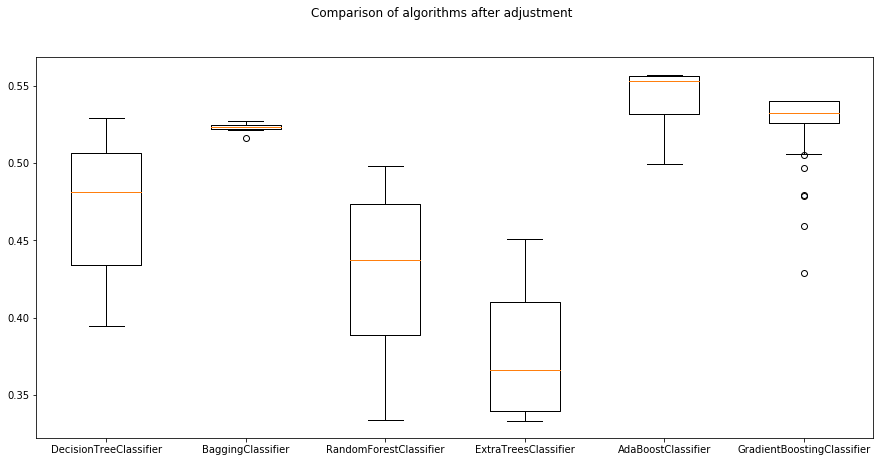

In [25]:
names = ['DecisionTreeClassifier', 'BaggingClassifier', 'RandomForestClassifier', 
         'ExtraTreesClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier']
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Comparison of algorithms after adjustment')
plt.boxplot(results_white)
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
plt.show()

Based on the minimum value of the interval distribution range (box), the high median value and minimum asymmetry of whiskers, we can conclude that the best results of the quality assessment of White wine in the training sample showed BaggingClassifier.

____

In [26]:
def transform_predictions_and_labels(y_predict_probability, y_test, n_classes):
    actual_labels_list = []
    probabilities_list = []
    for i in range(n_classes):
        actual_labels = list(map(lambda x: 1 if x == i else 0, y_test))
        actual_labels_list.append(actual_labels)
        probabilities_list.append(y_predict_probability[:, i])
    return actual_labels_list, probabilities_list

In [27]:
def plotting_roc_curves(actual_labels, probabilities, n_classes, figure_name):
    """Compute ROC curve and ROC area for each class in each fold"""
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(actual_labels[i], probabilities[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 7))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(figure_name)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

## Evaluation of models on the test sample

#### For red wine

Balanced accuracy: 0.6798919517272082

Confusion matrix:
 [[  4   3   0]
 [ 24 272  87]
 [  0  15  47]]

Classification report:
               precision    recall  f1-score   support

           0       0.14      0.57      0.23         7
           1       0.94      0.71      0.81       383
           2       0.35      0.76      0.48        62

    accuracy                           0.71       452
   macro avg       0.48      0.68      0.51       452
weighted avg       0.85      0.71      0.75       452



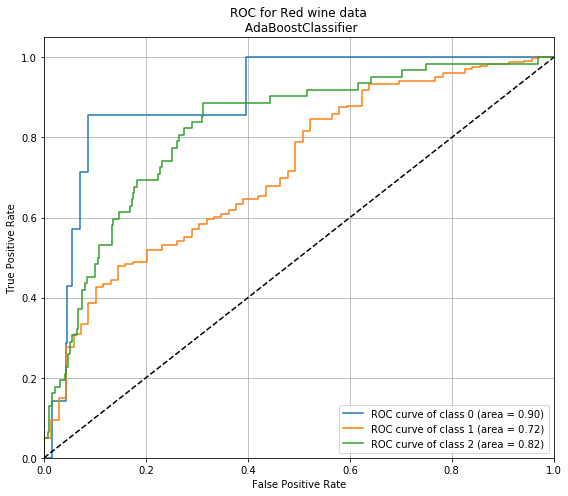

In [28]:
# training of the model with the best parameters on training data
model_red = AdaBoostClassifier(n_estimators=800, random_state=seed)
model_red.fit(x_train_r, y_train_r)

# model evaluation on test data
predictions = model_red.predict(x_test_r)

print('Balanced accuracy:', balanced_accuracy_score(y_test_r, predictions))
print('\nConfusion matrix:\n', confusion_matrix(y_test_r, predictions))
print('\nClassification report:\n', classification_report(y_test_r, predictions, labels=[0, 1, 2]))

classes = 3
y_prob_red = model_red.predict_proba(x_test_r)
transform_labels, transform_prob = transform_predictions_and_labels(y_prob_red, y_test_r, classes)

title = 'ROC for Red wine data\n AdaBoostClassifier'
plotting_roc_curves(transform_labels, transform_prob, classes, title)

The values of confusion matrix and F-score show that the AdaBoostClassifier model does not classify classes 0 and 2 well.  
From the dependencies of the AUC ROC metrics we can see that the model defines classes 0 and 2 well.

Balanced accuracy: 0.7562356366786588

Confusion matrix:
 [[  6   1   0]
 [ 43 275  65]
 [  2  17  43]]

Classification report:
               precision    recall  f1-score   support

           0       0.12      0.86      0.21         7
           1       0.94      0.72      0.81       383
           2       0.40      0.69      0.51        62

    accuracy                           0.72       452
   macro avg       0.48      0.76      0.51       452
weighted avg       0.85      0.72      0.76       452



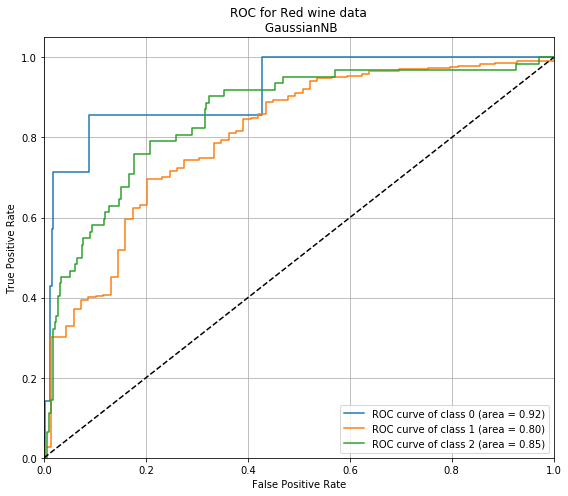

In [29]:
# model training on training data
model_red_gaussian = GaussianNB()
model_red_gaussian.fit(x_train_r, y_train_r)

# model evaluation on test data
predictions = model_red_gaussian.predict(x_test_r)

print('Balanced accuracy:', balanced_accuracy_score(y_test_r, predictions))
print('\nConfusion matrix:\n', confusion_matrix(y_test_r, predictions))
print('\nClassification report:\n', classification_report(y_test_r, predictions))

classes = 3
y_prob_red = model_red_gaussian.predict_proba(x_test_r)
transform_labels, transform_prob = transform_predictions_and_labels(y_prob_red, y_test_r, classes)

title = 'ROC for Red wine data\n GaussianNB'
plotting_roc_curves(transform_labels, transform_prob, classes, title)

Comparing the values of Balanced accuracy, confusion matrix, f1-score and AUC ROC metrics of the AdaBoostClassifier and GaussianNB models, we can conclude that the GaussianNB model performs the task of classification on the red wine test data better.

#### For white wine

Balanced accuracy: 0.5773067522150932

Confusion matrix:
 [[   7   28    0]
 [   2 1044   45]
 [   0  136  184]]

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.20      0.32        35
           1       0.86      0.96      0.91      1091
           2       0.80      0.57      0.67       320

    accuracy                           0.85      1446
   macro avg       0.82      0.58      0.63      1446
weighted avg       0.85      0.85      0.84      1446



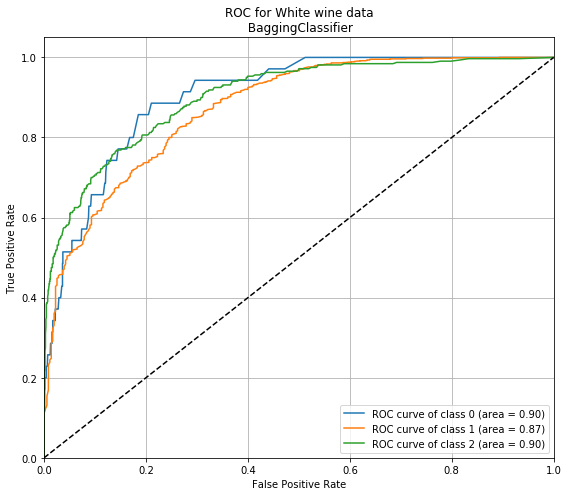

In [30]:
# model training on training data
model_white = BaggingClassifier(n_estimators=800, random_state=seed)
model_white.fit(x_train_w, y_train_w)

# model evaluation on test data
predictions = model_white.predict(x_test_w)

print('Balanced accuracy:', balanced_accuracy_score(y_test_w, predictions))
print('\nConfusion matrix:\n', confusion_matrix(y_test_w, predictions))
print('\nClassification report:\n', classification_report(y_test_w, predictions))

classes = 3
y_prob_white = model_white.predict_proba(x_test_w)
transform_labels, transform_prob = transform_predictions_and_labels(y_prob_white, y_test_w, classes)

title = 'ROC for White wine data\n BaggingClassifier'
plotting_roc_curves(transform_labels, transform_prob, classes, title)

The F-score and Confusion matrix values show that BaggingClassifier does not classify class 0 well, unlike class 1 and 2, which affects the value of the Balanced accuracy metrics. However, the ROC curves graphs show that the model defines all classes well.

Balanced accuracy: 0.5160790668237965

Confusion matrix:
 [[  3  23   9]
 [ 24 791 276]
 [  0  84 236]]

Classification report:
               precision    recall  f1-score   support

           0       0.11      0.09      0.10        35
           1       0.88      0.73      0.80      1091
           2       0.45      0.74      0.56       320

    accuracy                           0.71      1446
   macro avg       0.48      0.52      0.48      1446
weighted avg       0.77      0.71      0.73      1446



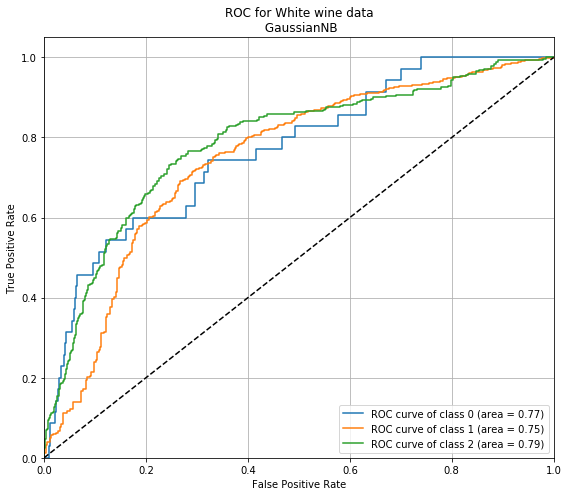

In [31]:
# model training on training data
model_white_gaussian = GaussianNB()
model_white_gaussian.fit(x_train_w, y_train_w)

# model evaluation on test data
predictions = model_white_gaussian.predict(x_test_w)

print('Balanced accuracy:', balanced_accuracy_score(y_test_w, predictions))
print('\nConfusion matrix:\n', confusion_matrix(y_test_w, predictions))
print('\nClassification report:\n', classification_report(y_test_w, predictions))

classes = 3
y_prob_white = model_white_gaussian.predict_proba(x_test_w)
transform_labels, transform_prob = transform_predictions_and_labels(y_prob_white, y_test_w, classes)

title = 'ROC for White wine data\n GaussianNB'
plotting_roc_curves(transform_labels, transform_prob, classes, title)

Comparing the values of Balanced accuracy, confusion matrix, f1-score and AUC ROC models BaggingClassifier and GaussianNB, we can conclude that BaggingClassifier model performs better in classifying on White wine test data.

____

## Oversampling

#### For red wine

In [32]:
# oversampling
ros = RandomOverSampler(random_state=seed)
x_re_sampled_red, y_re_sampled_red = ros.fit_resample(x_train_r, y_train_r)

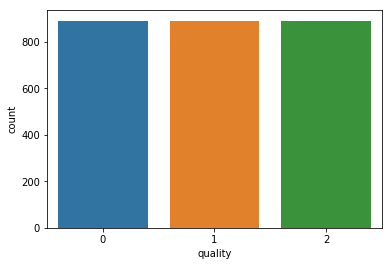

In [33]:
U = {'x_vector': y_re_sampled_red}
sns.countplot(x='x_vector', data=U)

Balanced accuracy: 0.6783057196600529

Confusion matrix:
 [[  4   3   0]
 [ 30 264  89]
 [  1  13  48]]

Classification report:
               precision    recall  f1-score   support

           0       0.11      0.57      0.19         7
           1       0.94      0.69      0.80       383
           2       0.35      0.77      0.48        62

    accuracy                           0.70       452
   macro avg       0.47      0.68      0.49       452
weighted avg       0.85      0.70      0.74       452



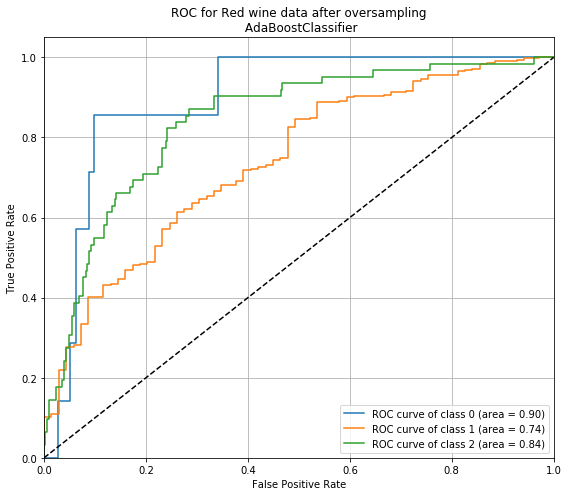

In [34]:
# model training on training data
model_red = AdaBoostClassifier(n_estimators=800, random_state=seed)
model_red.fit(x_re_sampled_red, y_re_sampled_red)

# model evaluation on test data
predictions = model_red.predict(x_test_r)

print('Balanced accuracy:', balanced_accuracy_score(y_test_r, predictions))
print('\nConfusion matrix:\n', confusion_matrix(y_test_r, predictions))
print('\nClassification report:\n', classification_report(y_test_r, predictions, labels=[0, 1, 2]))

classes = 3
y_prob_red = model_red.predict_proba(x_test_r)
transform_labels, transform_prob = transform_predictions_and_labels(y_prob_red, y_test_r, classes)

title = 'ROC for Red wine data after oversampling\n AdaBoostClassifier'
plotting_roc_curves(transform_labels, transform_prob, classes, title)

Oversampling of the Red wine training data had a negative impact on the Balanced accuracy, Confusion matrix and F-score values for the AdaBoostClassifier model.

Balanced accuracy: 0.6946533350980415

Confusion matrix:
 [[  6   1   0]
 [113 161 109]
 [  3   9  50]]

Classification report:
               precision    recall  f1-score   support

           0       0.05      0.86      0.09         7
           1       0.94      0.42      0.58       383
           2       0.31      0.81      0.45        62

    accuracy                           0.48       452
   macro avg       0.44      0.69      0.38       452
weighted avg       0.84      0.48      0.56       452



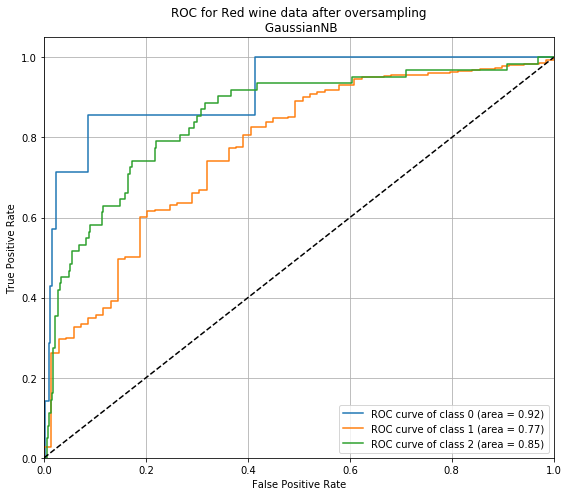

In [35]:
# model training on training data
model_red = GaussianNB()
model_red.fit(x_re_sampled_red, y_re_sampled_red)

# model evaluation on unbalanced test data
predictions = model_red.predict(x_test_r)

print('Balanced accuracy:', balanced_accuracy_score(y_test_r, predictions))
print('\nConfusion matrix:\n', confusion_matrix(y_test_r, predictions))
print('\nClassification report:\n', classification_report(y_test_r, predictions))

classes = 3
y_prob_red = model_red.predict_proba(x_test_r)
transform_labels, transform_prob = transform_predictions_and_labels(y_prob_red, y_test_r, classes)

title = 'ROC for Red wine data after oversampling\n GaussianNB'
plotting_roc_curves(transform_labels, transform_prob, classes, title)

Oversampling of the Wed wine training data had a negative impact on the Balanced accuracy, Confusion matrix and F-score values for the GaussianNB model.

#### For white wine

In [36]:
# oversampling
ros = RandomOverSampler(random_state=seed)
x_re_sampled_white, y_re_sampled_white = ros.fit_resample(x_train_w, y_train_w)

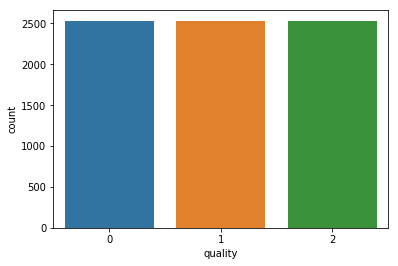

In [37]:
U_white = {'x_vector': y_re_sampled_white}
sns.countplot(x='x_vector', data=U_white)

Balanced accuracy: 0.6302087425254245

Confusion matrix:
 [[ 11  24   0]
 [ 10 997  84]
 [  0 108 212]]

Classification report:
               precision    recall  f1-score   support

           0       0.52      0.31      0.39        35
           1       0.88      0.91      0.90      1091
           2       0.72      0.66      0.69       320

    accuracy                           0.84      1446
   macro avg       0.71      0.63      0.66      1446
weighted avg       0.84      0.84      0.84      1446



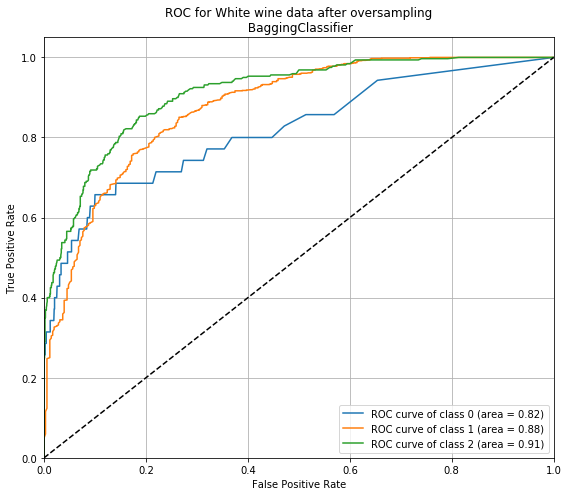

In [38]:
# model training on training data
model_white = BaggingClassifier(n_estimators=800, random_state=seed)
model_white.fit(x_re_sampled_white, y_re_sampled_white)

# model evaluation on test data
predictions = model_white.predict(x_test_w)

print('Balanced accuracy:', balanced_accuracy_score(y_test_w, predictions))
print('\nConfusion matrix:\n', confusion_matrix(y_test_w, predictions))
print('\nClassification report:\n', classification_report(y_test_w, predictions))

classes = 3
y_prob_white = model_white.predict_proba(x_test_w)
transform_labels, transform_prob = transform_predictions_and_labels(y_prob_white, y_test_w, classes)

title = 'ROC for White wine data after oversampling\n BaggingClassifier'
plotting_roc_curves(transform_labels, transform_prob, classes, title)

After the Oversampling of the White wine training data, the value of the Balanced accuracy has been increased by increasing the accuracy of the class 0 determination. However, the AUC ROC characteristics for class 0 have decreased.

Balanced accuracy: 0.5961936951682598

Confusion matrix:
 [[ 18   8   9]
 [208 497 386]
 [ 10  48 262]]

Classification report:
               precision    recall  f1-score   support

           0       0.08      0.51      0.13        35
           1       0.90      0.46      0.60      1091
           2       0.40      0.82      0.54       320

    accuracy                           0.54      1446
   macro avg       0.46      0.60      0.42      1446
weighted avg       0.77      0.54      0.58      1446



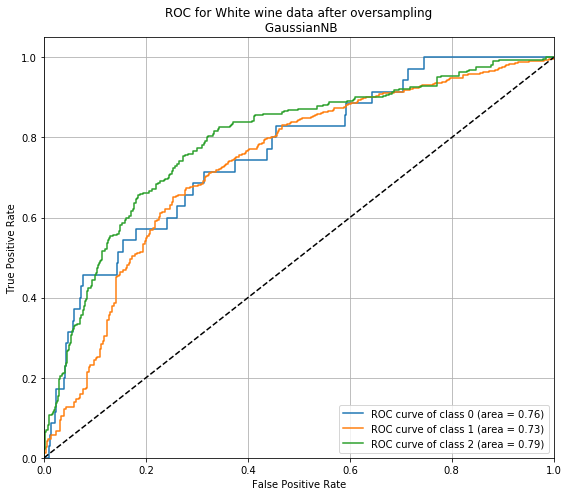

In [39]:
# model training on training data
model_white = GaussianNB()
model_white.fit(x_re_sampled_white, y_re_sampled_white)

# model evaluation on unbalanced test data
predictions = model_white.predict(x_test_w)

print('Balanced accuracy:', balanced_accuracy_score(y_test_w, predictions))
print('\nConfusion matrix:\n', confusion_matrix(y_test_w, predictions))
print('\nClassification report:\n', classification_report(y_test_w, predictions))

classes = 3
y_prob_white = model_white.predict_proba(x_test_w)
transform_labels, transform_prob = transform_predictions_and_labels(y_prob_white, y_test_w, classes)

title = 'ROC for White wine data after oversampling\n GaussianNB'
plotting_roc_curves(transform_labels, transform_prob, classes, title)

Overseampling has improved the accuracy of class 0 determination. However, the model became more difficult to distinguish the 1st class.
This had a minor impact on the AUC ROC characteristics.

____

## Training of the best models on full datasets and saving it

#### For red wine

In [40]:
# model training
model_red_gnb_final = GaussianNB()
model_red_gnb_final.fit(x_red_without_anomalies, y_red_without_anomalies)
print('The model is trained!')

The model is trained!


In [41]:
# saving model
PATH = 'saved_models/'
dump(model_red_gnb_final, PATH + 'red_wine_quality_GaussianNB.joblib')

['saved_models/red_wine_quality_GaussianNB.joblib']

#### For white wine

In [42]:
# oversampling for Wed wine data
ros = RandomOverSampler(random_state=seed)
x_re_sampled_all, y_re_sampled_all = ros.fit_resample(x_white_without_anomalies, y_white_without_anomalies)

# model training
model_white_bc_final = BaggingClassifier(n_estimators=800, random_state=seed)
model_white_bc_final.fit(x_re_sampled_all, y_re_sampled_all)print('The model is trained!')

The model is trained!


In [43]:
# saving model
PATH = 'saved_models/'
dump(model_white_bc_final, PATH + 'white_wine_quality_BaggingClassifier.joblib')

['saved_models/white_wine_quality_BaggingClassifier.joblib']

## Conclusion

Low values of metrics for red and white wine can be caused by the following reasons:
* small dataset;
* unbalanced classes;
* initial subjective assessment of the quality of wine, which is difficult to predict.

Ways to improve:
* using of regularization methods;
* reducing the number of classes to two;
* useing model ensembles;
* selection of hyperparameters of models.